# A lovely NN in Pytorch

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/colab_tutorials/blob/main/lecture9/a_lovely_NN_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [1]:
# !pip install torch pandas

## Get & set up data

The dataset describes the crystallization tendency of polymers. It has fingerprints for each polymer attached that were generated using [PSMILES](https://psmiles.readthedocs.io/).

Columns:
- `smiles` contains the PSMILES string of the polymer
- `property` contains the property string 'xc'
- `value` contains the tendency to crystallize in `%`
- `fingerprint` contains the fingerprint of 2049 components

In [2]:
import pandas as pd

df = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/colab_tutorials/main/lecture2/data/polymers_tend_to_crystalize.json"
)
df

,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


## Subclass pytorch `Dataset` to create own Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from sklearn.model_selection import train_test_split


class CrystallinityPolymers(Dataset):
    """Crystallinity of polymers."""

    def __init__(self, train=True, shuffle=True, transform=None):
        """
        Initializes the class

        Arguments:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train = train
        self.transform = transform

        # Load dataset
        self._df = pd.read_json(
            "https://raw.githubusercontent.com/kuennethgroup/colab_tutorials/main/lecture2/data/polymers_tend_to_crystalize.json"
        )
        # Split dataset
        self.df_train, self.df_test = train_test_split(
            self._df, shuffle=True, random_state=123
        )
        # self.df is train or test, depending on self.train
        self.df = self.df_train if self.train else self.df_test

        self.number_of_fingerprints = len(self.df["fingerprint"].iloc[0])

    # -- MAGIC method
    # This functions overwrites what's return on calling len(object)
    def __len__(self):
        return len(self.df)

    # -- MAGIC method
    # Defines what happen if we call [] on an object of this class
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        fingerprints = np.stack(self.df["fingerprint"].iloc[idx], dtype=np.float32)

        pred = np.array(self.df["value"].iloc[idx], dtype=np.float32)

        sample = {"xc": pred, "fp": fingerprints}

        if self.transform:
            sample = self.transform(sample)

        return sample


trainset = CrystallinityPolymers(train=True)
testset = CrystallinityPolymers(train=False)

print(f"Train: {len(trainset)}; test {len(testset)}")

print(trainset[0:3])
for i in trainset:
    print(i)
    break

print(trainset.number_of_fingerprints)

Train: 324; test 108
{'xc': array([19.53,  5.67, 47.8 ], dtype=float32), 'fp': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}
{'xc': array(19.53, dtype=float32), 'fp': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
2048


In [4]:
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False)


# arrays are now tensors
next(iter(train_dataloader))

{'xc': tensor([19.5300,  5.6700, 47.8000, 63.8000, 29.6300,  1.6100, 16.8600, 37.0800,
         26.3300, 73.3800, 27.1000, 11.4700, 26.1600, 15.1100, 75.0600, 36.9800,
         18.1000, 14.5200, 44.3800, 29.1800, 30.3200, 10.1400, 12.7500, 55.4000,
          4.3800, 64.2400, 35.5300, 57.0700, 24.7000, 33.9700, 25.8700, 13.8600,
         31.2600, 43.6900, 83.8700, 25.5900, 34.0900, 16.7300, 22.4900, 44.0300,
         33.2200, 73.5500, 15.7100, 27.7400, 32.7000, 18.1400, 21.4900, 12.5200,
         36.0300, 53.8600,  9.7900, 60.7400,  2.9200, 48.4100, 30.1700, 78.2700,
         29.7700, 73.0700,  8.6300, 11.7800, 72.9700, 30.7800, 53.4000, 92.7500]),
 'fp': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])}

## Build the neral network

In [5]:
from torch import nn


class ALovelyNet(nn.Module):
    def __init__(self, n_in):
        """
        Initialize all the layers here
        """

        super().__init__()
        self.l1 = nn.Linear(n_in, 200)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.4)
        self.l2 = nn.Linear(200, 100)
        self.a2 = nn.SELU()
        self.d2 = nn.Dropout(0.4)
        self.output = nn.Linear(100, 1)

    def forward(self, x):
        """
        Describes a forward pass
        """
        for l in [self.l1, self.a1, self.d1]:
            x = l(x)

        for l in [self.l2, self.a2, self.d2]:
            x = l(x)

        return self.output(x)


model = ALovelyNet(trainset.number_of_fingerprints)
print(model)

ALovelyNet(
  (l1): Linear(in_features=2048, out_features=200, bias=True)
  (a1): ReLU()
  (d1): Dropout(p=0.4, inplace=False)
  (l2): Linear(in_features=200, out_features=100, bias=True)
  (a2): SELU()
  (d2): Dropout(p=0.4, inplace=False)
  (output): Linear(in_features=100, out_features=1, bias=True)
)


In [6]:
from torchinfo import summary


# 20 batches, 2046 fingerprints
batch_size = 10
x = torch.rand(batch_size, trainset.number_of_fingerprints)
_model = ALovelyNet(trainset.number_of_fingerprints)
out = _model(x)

print(out)
summary(
    _model,
    input_size=x.shape,
    device="cpu",
    col_names=("input_size", "output_size", "num_params"),
)

tensor([[ 0.0126],
        [-0.2642],
        [ 0.1260],
        [-0.0079],
        [ 0.0366],
        [ 0.1134],
        [ 0.0547],
        [-0.1133],
        [-0.1427],
        [-0.2432]], grad_fn=<AddmmBackward0>)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ALovelyNet                               [10, 2048]                [10, 1]                   --
├─Linear: 1-1                            [10, 2048]                [10, 200]                 409,800
├─ReLU: 1-2                              [10, 200]                 [10, 200]                 --
├─Dropout: 1-3                           [10, 200]                 [10, 200]                 --
├─Linear: 1-4                            [10, 200]                 [10, 100]                 20,100
├─SELU: 1-5                              [10, 100]                 [10, 100]                 --
├─Dropout: 1-6                           [10, 100]                 [10, 100]                 --
├─Linear: 1-7                            [10, 100]                 [10, 1]                   101
Total params: 430,001
Trainable params: 430,001
Non-trainable params: 0
Total mult-adds (M): 4.30
Input size (MB): 0.08
F

Get the parameters

In [7]:
for name, param in _model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: l1.weight | Size: torch.Size([200, 2048]) | Values : tensor([[-0.0013, -0.0049,  0.0114,  ...,  0.0027, -0.0018, -0.0181],
        [-0.0146, -0.0058, -0.0193,  ..., -0.0159, -0.0114,  0.0205]],
       grad_fn=<SliceBackward0>) 

Layer: l1.bias | Size: torch.Size([200]) | Values : tensor([0.0018, 0.0167], grad_fn=<SliceBackward0>) 

Layer: l2.weight | Size: torch.Size([100, 200]) | Values : tensor([[-0.0153, -0.0535,  0.0668, -0.0416, -0.0665, -0.0576, -0.0610,  0.0372,
         -0.0165,  0.0627, -0.0199, -0.0391, -0.0485, -0.0171,  0.0497, -0.0541,
          0.0520,  0.0063,  0.0466,  0.0597, -0.0588, -0.0538, -0.0615,  0.0123,
         -0.0632, -0.0639,  0.0405,  0.0378,  0.0439, -0.0380,  0.0279,  0.0242,
         -0.0560, -0.0702, -0.0337, -0.0514,  0.0404,  0.0451, -0.0406,  0.0014,
          0.0555,  0.0668, -0.0409, -0.0355, -0.0054,  0.0358, -0.0451, -0.0610,
          0.0546,  0.0632,  0.0283, -0.0032,  0.0673, -0.0046,  0.0444,  0.0151,
          0.0649, -0.0573,  0.042

## Training

In [8]:
def train_model(model, n_epochs, optimizer, criterion):
    """
    This functions trains the model
    """

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    for epoch in range(n_epochs):  # loop over the dataset n_epochs times
        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        for batch, data in enumerate(train_dataloader):
            # get the inputs
            inputs = data["fp"]
            truth = data["xc"]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass (class the forward method)
            prediction = model(inputs)

            # Flatten 2D array to 1D array
            # Because pred is a 1D array
            prediction = prediction.squeeze()

            # Compute the MSE loss of prediction and true values
            loss = criterion(prediction, truth)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval()  # prep model for evaluation
        for batch, data in enumerate(test_dataloader):
            # get the inputs
            inputs = data["fp"]
            truth = data["xc"]

            # forward pass: compute predicted outputs by passing inputs to the model
            prediction = model(inputs)
            prediction = prediction.squeeze()

            # calculate the loss
            loss = criterion(prediction, truth)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print(
            f"[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] "
            f"train_loss: {train_loss:.5f} "
            f"valid_loss: {valid_loss:.5f}"
        )
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

    return model, avg_train_losses, avg_valid_losses

In [9]:
import torch.optim as optim

# the net we want to train
lovely_net = ALovelyNet(trainset.number_of_fingerprints)

# MSE :)
criterion = nn.MSELoss()

optimizer = optim.Adam(lovely_net.parameters(), lr=0.001)


trained_model, train_loss, valid_loss = train_model(
    lovely_net, 200, optimizer, criterion
)

[  0/200] train_loss: 1958.03800 valid_loss: 1921.23163
[  1/200] train_loss: 1765.83608 valid_loss: 1696.08624
[  2/200] train_loss: 1493.49325 valid_loss: 1418.89764
[  3/200] train_loss: 1190.44856 valid_loss: 1165.22736
[  4/200] train_loss: 972.55512 valid_loss: 1067.01056
[  5/200] train_loss: 820.87071 valid_loss: 1047.02100
[  6/200] train_loss: 828.13689 valid_loss: 983.78000
[  7/200] train_loss: 786.52979 valid_loss: 920.46887
[  8/200] train_loss: 688.78469 valid_loss: 875.96158
[  9/200] train_loss: 645.75964 valid_loss: 830.34137
[ 10/200] train_loss: 565.09395 valid_loss: 784.61581
[ 11/200] train_loss: 527.25872 valid_loss: 742.54260
[ 12/200] train_loss: 481.47457 valid_loss: 699.45340
[ 13/200] train_loss: 399.80049 valid_loss: 657.67047
[ 14/200] train_loss: 392.41953 valid_loss: 622.73416
[ 15/200] train_loss: 367.95739 valid_loss: 588.37430
[ 16/200] train_loss: 342.62594 valid_loss: 556.14673
[ 17/200] train_loss: 305.06054 valid_loss: 527.59718
[ 18/200] train_lo

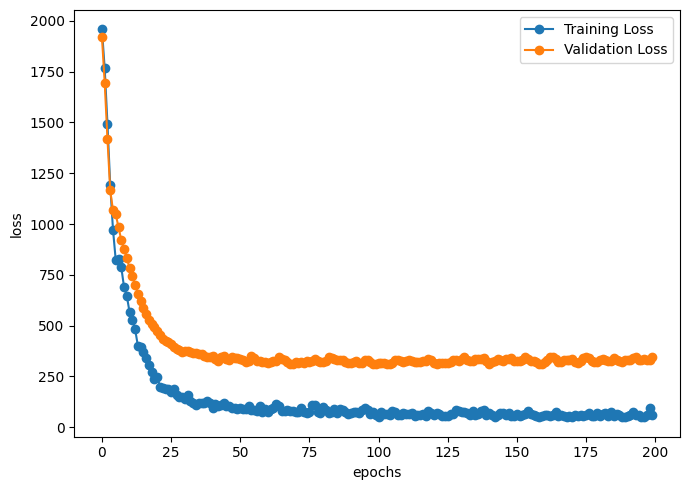

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(np.arange(len(train_loss)), train_loss, "o-", label="Training Loss")
ax.plot(np.arange(len(valid_loss)), valid_loss, "o-", label="Validation Loss")
ax.legend()
ax.set_ylabel("loss")
ax.set_xlabel("epochs")

fig.tight_layout()

rmse = 18.176332
r2 = 0.47533664620388494


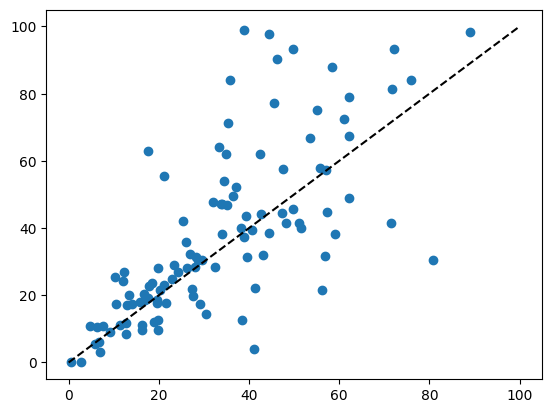

In [11]:
from sklearn.metrics import r2_score, mean_squared_error

predictions = []
truth = []
trained_model.eval()
for batch, data in enumerate(test_dataloader):
    with torch.no_grad():
        predictions.append(trained_model(data["fp"]).squeeze().numpy())
        truth.append(data["xc"])
predictions = np.hstack(predictions)
truth = np.hstack(truth)


r2 = r2_score(truth, predictions)
rmse = mean_squared_error(truth, predictions, squared=False)


fig, ax = plt.subplots(1, 1)

ax.plot(predictions, truth, "o")
ax.plot([0, 100], [0, 100], "k--")
print(f"{rmse = }")
print(f"{r2 = }")